In [1]:
import os, sys, subprocess, fitsio, shutil
from collections import Counter

import numpy as np
from astropy.table import Table
from astropy.io import fits

import desimodel.io
import desimodel.focalplane
import desimodel.footprint
from desitarget.targetmask import desi_mask, obsconditions
import matplotlib.pyplot as plt
%matplotlib inline

**Learning goals**

In this notebook you will learn how to:

* Generate mock files from simulations to feed into fiberassign.
* Run fiberassign using the files generated above.
* Explore the outputs of fiberassign to estimate its efficiency.

In this example, for simplicity, only QSO targets are generated from the simulation.


This notebook reuses code by S. Bailey https://github.com/desihub/tutorials/blob/master/FiberAssign.ipynb

In [12]:
workdir = os.getenv('SCRATCH') + '/desi/test/fiberassign_mock'
os.makedirs(workdir, exist_ok=True)
os.chdir(workdir)
outdir = workdir + '/output'
os.makedirs(outdir, exist_ok=True)
shutil.copy(os.path.join(os.getenv('SCRATCH'), 'tutorials', 'input.yaml'), workdir)

'/global/cscratch1/sd/forero/desi/test/fiberassign_mock/input.yaml'

In [13]:
# This is the content of the configuration file to be passed to select_mock_targets
!cat input.yaml

# mock target configuration file
targets:
    ELG: {
        target_type: ELG,
        mockfile: '{DESI_ROOT}/mocks/DarkSky/v1.0.1/elg_0_inpt.fits',
        format: gaussianfield,
        density: 2400,
    }
    LRG: {
        target_type: LRG,
        mockfile: '{DESI_ROOT}/mocks/DarkSky/v1.0.1/lrg_0_inpt.fits',
        format: gaussianfield,
        density: 480,
    }
    QSO: {
        target_type: QSO,
        mockfile: '{DESI_ROOT}/mocks/DarkSky/v1.0.1/qso_0_inpt.fits',
        format: gaussianfield,
        zmax_qso: 1.8,
        use_simqso: True,
        density: 120,
    }
    LYA: {
        target_type: QSO,
        mockfile: '{DESI_ROOT}/mocks/lya_forest/london/v4.0/master.fits',
        format: CoLoRe,
        nside_lya: 16,
        zmin_lya: 1.8,
        density: 50,
        use_simqso: True,
        balprob: 0.0,
        add_dla: True,
    }
    MWS_MAIN: {
        target_type: STAR,
        mockfile: '{DESI_ROOT}/mocks/mws/galaxia/alpha/v0.0.6/healpix',
        nside_ga

Some more files needed to run fiberassign

In [4]:
mtlfile = os.path.join(workdir, 'mtl.fits')
truthfile = os.path.join(workdir, 'truth.fits')
starfile = os.path.join(workdir, 'std.fits')
targetcutfile = os.path.join(workdir, 'targets.fits') 
skycutfile = os.path.join(workdir, 'sky.fits') 
tilefile = os.path.join(workdir, "tiles.fits")

In [5]:
# tile selection
program = "dark"

tiles = desimodel.io.load_tiles()
bright = tiles['PROGRAM']=='BRIGHT'
    
small = ((tiles['RA']>12) & (tiles['RA']<20) & (tiles['DEC']<1) & (tiles['DEC']>-1))

if program=="bright":
    Table(tiles[(bright)&(small)]).write(tilefile, overwrite=True)
else:
    Table(tiles[(~bright) & (small)]).write(tilefile, overwrite=True)

print("Wrote tiles to {}".format(tilefile))

Wrote tiles to /global/cscratch1/sd/forero/desi/test/fiberassign_mock/tiles.fits


In [6]:
!pwd
!ls

/global/cscratch1/sd/forero/desi/test/fiberassign_mock
input.yaml  output  tiles.fits


In [24]:
cmd = "srun -A desi -N 2 -n 16 -c 8"  # -c 8 not 4 for hyperthreading
cmd += " -C haswell -t 01:00:00 --qos interactive "
cmd += " mpi_select_mock_targets --no-spectra --nproc 4 --nside 32 --seed 10"
cmd += " -c ./input.yaml "
cmd += " --output_dir ./ "
cmd += " --tiles ./tiles.fits"
print(cmd)

srun -A desi -N 2 -n 16 -c 8 -C haswell -t 01:00:00 --qos interactive  mpi_select_mock_targets --no-spectra --nproc 4 --nside 32 --seed 10 -c ./input.yaml  --output_dir ./  --tiles ./tiles.fits


In [14]:
# To run target selection comment out these lines. it should take 5 minutes
#print('RUNNING: '+cmd)
#err = subprocess.call(cmd.split())
#print(err)
#assert err == 0


In [25]:
cmd = 'join_mock_targets --overwrite --mockdir ./'
print('RUNNING: '+cmd)
err = subprocess.call(cmd.split())
print(err)
assert err == 0

RUNNING: join_mock_targets --overwrite --mockdir ./
0


Text(0,0.5,'DEC')

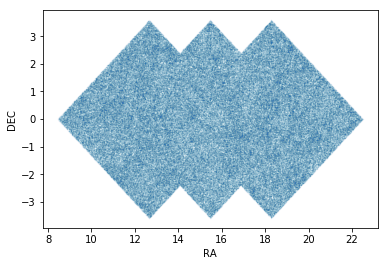

In [26]:
mtldata = Table.read('mtl.fits')
plt.scatter(mtldata['RA'], mtldata['DEC'],s=0.1, alpha=0.1)
plt.xlabel('RA')
plt.ylabel('DEC')

In [17]:
# Run fiberassign
cmd = 'fiberassign --mtl mtl.fits --stdstar standards-dark.fits --sky sky.fits'
cmd += ' --footprint ./tiles.fits'
cmd += ' --outdir ./output/'
cmd = cmd.format(outdir=outdir)

In [18]:
#- Cleanup old files if needed
for tileid in tiles['TILEID']:
    tilefile = '{}/tile-{:06d}.fits'.format(outdir, tileid)
    if os.path.exists(tilefile):
        os.remove(tilefile)
        
print('RUNNING: '+cmd)
err = subprocess.call(cmd.split())
print(err)
assert err == 0

RUNNING: fiberassign --mtl mtl.fits --stdstar standards-dark.fits --sky sky.fits --footprint ./tiles.fits --outdir ./output/
0


In [19]:
!ls output

fiberassign_000543.fits  fiberassign_017829.fits  tile-007349.fits
fiberassign_000544.fits  fiberassign_018873.fits  tile-012065.fits
fiberassign_001587.fits  fiberassign_023589.fits  tile-012067.fits
fiberassign_006305.fits  fiberassign_024633.fits  tile-013111.fits
fiberassign_006306.fits  fiberassign_024635.fits  tile-017827.fits
fiberassign_007349.fits  tile-000543.fits	  tile-017829.fits
fiberassign_012065.fits  tile-000544.fits	  tile-018873.fits
fiberassign_012067.fits  tile-001587.fits	  tile-023589.fits
fiberassign_013111.fits  tile-006305.fits	  tile-024633.fits
fiberassign_017827.fits  tile-006306.fits	  tile-024635.fits


In [20]:
tiles = Table.read("tiles.fits")
targets = Table.read("mtl.fits")

Text(0,0.5,'DEC [deg]')

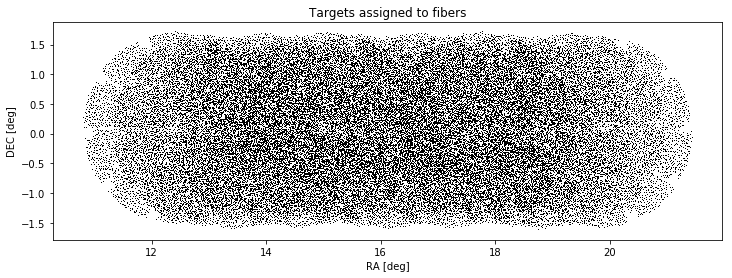

In [21]:
# Gather all outputs
assignments = list()
for tileid in tiles['TILEID']:
    tilefile = '{}/tile-{:06d}.fits'.format(outdir, tileid)
    assignments.append(Table.read(tilefile, hdu=1))
    
assigned_targetids = np.concatenate([tmp['TARGETID'] for tmp in assignments])
isAssigned = np.in1d(targets['TARGETID'], assigned_targetids)

plt.figure(figsize=(12,4))
plt.plot(targets['RA'][isAssigned], targets['DEC'][isAssigned], 'k,')
plt.title('Targets assigned to fibers')
plt.xlabel('RA [deg]')
plt.ylabel('DEC [deg]')

Text(0,0.5,'DEC [deg]')

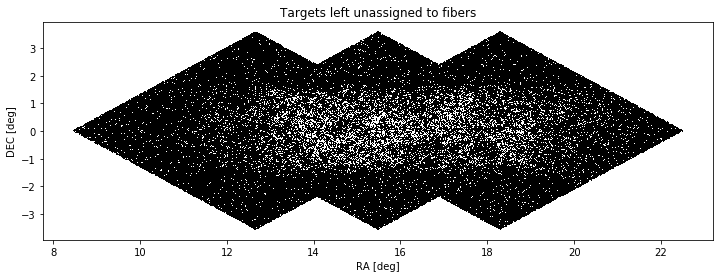

In [22]:
plt.figure(figsize=(12,4))
plt.plot(targets['RA'][~isAssigned], targets['DEC'][~isAssigned], 'k,')
plt.title('Targets left unassigned to fibers')
plt.xlabel('RA [deg]')
plt.ylabel('DEC [deg]')